In [1]:
import numpy as np
import h5py, glob, os
import nilearn
from nilearn import image, plotting, masking
from nilearn.glm import threshold_stats_img
import pandas as pd
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (26, 20)


from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs
from nilearn.plotting import plot_stat_map, plot_anat, plot_img


print('RUNNING')


subjects = [790,811,813,860]
sessions = np.arange(2,11) 

# subjects = [813]
# sessions = [7]



n_volumes = 738
TR = 0.75

alpha = .001
cluster_threshold = 30

subject = 790
session = 2


subject = str(subject)
session_n = str(session)



if int(session_n) < 10:
    session_n = session_n.zfill(2)
print(subject, session_n)

RUNNING
790 02


In [2]:
confound_fns = ('/user_data/kbond/fmriprep_confound_denoise/sub-{}_session-{}_*_confound_df.csv'.format(subject, int(session_n)))
confound_files = glob.glob(confound_fns)      
confound_files.sort()

In [3]:
confound_dfs = [pd.read_csv(f) for f in confound_files]

In [4]:
len(confound_dfs)

5

In [5]:
confound_dfs[:2]

[        rot_x     rot_y         rot_z   trans_x   trans_y   trans_z  \
 0    0.000000 -0.000000  0.000000e+00  0.000000 -0.006812  0.000000   
 1    0.000434 -0.000028  0.000000e+00  0.005268 -0.049442  0.032351   
 2    0.000477  0.000101  0.000000e+00  0.012363 -0.038310  0.046007   
 3   -0.000003  0.000176  0.000000e+00  0.006301  0.066997  0.015727   
 4   -0.000029  0.000101 -1.445400e-04  0.003542  0.030229 -0.007760   
 5    0.000411  0.000351  0.000000e+00  0.006304 -0.032974  0.029155   
 6    0.000411  0.000101 -1.569690e-04  0.014073 -0.011346  0.036858   
 7    0.000195  0.000351  0.000000e+00  0.006161  0.057962  0.031502   
 8    0.000411  0.000101 -1.798640e-04  0.008544 -0.021904  0.029040   
 9    0.000411 -0.000031 -5.207920e-05 -0.002076 -0.048487  0.032904   
 10   0.000108  0.000351  0.000000e+00  0.003430  0.046183  0.026479   
 11   0.000323  0.000428 -5.473410e-05  0.010584  0.023573  0.034270   
 12   0.000691  0.000332 -1.483390e-04  0.012013 -0.043181  0.04

In [6]:
epi_fns = glob.glob('/lab_data/coaxlab/Projects/loki_1/fmriprep_BOLD_data/sub-{}/ses-{}/func/*space-T1w_desc-preproc_bold.nii.gz'.format(subject, session_n))
print(epi_fns)
epi_fns.sort()

epi_imgs = []

for fn in epi_fns:
   print(fn)
   epi_img = nilearn.image.load_img(fn)
   epi_imgs.append(epi_img)

print(epi_imgs)


for img in epi_imgs:
    print(img.shape)
    assert img.shape == epi_imgs[0].shape

mean_img = image.mean_img(epi_imgs[0])

['/lab_data/coaxlab/Projects/loki_1/fmriprep_BOLD_data/sub-790/ses-02/func/sub-790_ses-02_task-lokicat_run-02_space-T1w_desc-preproc_bold.nii.gz', '/lab_data/coaxlab/Projects/loki_1/fmriprep_BOLD_data/sub-790/ses-02/func/sub-790_ses-02_task-lokicat_run-05_space-T1w_desc-preproc_bold.nii.gz', '/lab_data/coaxlab/Projects/loki_1/fmriprep_BOLD_data/sub-790/ses-02/func/sub-790_ses-02_task-lokicat_run-01_space-T1w_desc-preproc_bold.nii.gz', '/lab_data/coaxlab/Projects/loki_1/fmriprep_BOLD_data/sub-790/ses-02/func/sub-790_ses-02_task-lokicat_run-04_space-T1w_desc-preproc_bold.nii.gz', '/lab_data/coaxlab/Projects/loki_1/fmriprep_BOLD_data/sub-790/ses-02/func/sub-790_ses-02_task-lokicat_run-03_space-T1w_desc-preproc_bold.nii.gz']
/lab_data/coaxlab/Projects/loki_1/fmriprep_BOLD_data/sub-790/ses-02/func/sub-790_ses-02_task-lokicat_run-01_space-T1w_desc-preproc_bold.nii.gz
/lab_data/coaxlab/Projects/loki_1/fmriprep_BOLD_data/sub-790/ses-02/func/sub-790_ses-02_task-lokicat_run-02_space-T1w_desc-pre

In [7]:
epi_imgs

In [8]:
events_fn = glob.glob('/lab_data/coaxlab/Projects/loki_1/fmriprep_BOLD_data/events_temp/sub-0{}/ses-{}/func/*.tsv'.format(subject, session_n))
events_fn.sort()

n_trials_per_run = 60
stim_duration = 1.5

event_dfs = []

# need to get nonresponse trials too... 

for event_fn in events_fn:

        print(event_fn)

        trial_df = pd.DataFrame()

        all_events_df = pd.read_csv(event_fn, sep='\t|\,', engine='python'); print(all_events_df.columns)
        print('number of nonresponse trials :', n_trials_per_run - all_events_df.shape[0], 'head ' , all_events_df.head())
        
        
        
        
        trial_df['onset'] = all_events_df['onset'].copy()
        trial_df['trial_type'] = all_events_df['trial_type']
        trial_df['duration'] = stim_duration
        
        
        trial_df['subject'] = int(event_fn.split('sub-')[1][:4])
        trial_df['session'] = int(event_fn.split('ses-')[1][:2])
        trial_df['run_n'] = int(event_fn.split('run')[1][:2])

        run_n  = trial_df.run_n.unique()[0]



        event_dfs.append(trial_df)

        fn = os.path.join(os.path.dirname(event_fn), 'sub-0{}_ses{}_task-lokicat_run0{}_motor-ONLY_events.tsv').format(subject, session_n, run_n)


        print('file written as ', fn)

event_dfs[0].head()

print('n epis / n dfs ', len(epi_imgs), len(event_dfs))
# assert len(epi_imgs) == len(event_dfs), 'check run files'

print([type(fn) for fn in event_dfs])
print([fn.shape for fn in event_dfs])

epi_ordering = [print(img.get_filename()) for img in epi_imgs] # confirm ordering
event_ordering = [print(event.subject.unique(), event.session.unique(), event.run_n.unique()) for event in event_dfs] # confirm ordering
confound_ordering = [print(confound['sub'].unique(), confound.session.unique(), confound.run.unique()) for confound in confound_dfs] # confirm ordering


img_nan_check = [print('all values in epi finite? ', np.isfinite(img.get_fdata()).sum()  == (img.shape[0] * img.shape[1] * img.shape[2] * img.shape[3])) for img in epi_imgs]
event_nan_check = [print('all values in events finite? ', event.sum().notnull().all()) for event in event_dfs]

if (subject == '790') & (session_n == '04'): # sub 790 is missing beh. data for run 1 of session 4
        print('skipping data for run 01')
        epi_imgs.pop(0)
        print(epi_imgs, event_dfs)

/lab_data/coaxlab/Projects/loki_1/fmriprep_BOLD_data/events_temp/sub-0790/ses-02/func/sub-0790_ses02_task-lokicat_run01_08132019_150642_events.tsv
Index(['onset', 'duration', 'trial_type', 'rt', 'accuracy', 'epoch_length',
       'epoch_trial', 'epoch_number'],
      dtype='object')
number of nonresponse trials : 0 head         onset  duration  trial_type        rt  accuracy  epoch_length  \
0   0.016024  1.499981         0.0       NaN       NaN           7.0   
1   8.364996  1.499418         1.0  0.625790       0.0           7.0   
2  16.397269  1.500073         2.0       NaN       NaN           7.0   
3  27.095648  1.500250         3.0  0.673020       1.0           7.0   
4  37.994013  1.499424         4.0  0.614347       1.0           7.0   

   epoch_trial  epoch_number  
0          0.0           0.0  
1          1.0           0.0  
2          2.0           0.0  
3          3.0           0.0  
4          4.0           0.0  
file written as  /lab_data/coaxlab/Projects/loki_1/fmripre

In [9]:
from nilearn.image import index_img
sliced_epi_imgs = [index_img(img, slice(1, 738)) for img in epi_imgs]

# drop the first image to match shape of derivative for confounds (no nans allowed)

In [10]:
sliced_epi_imgs[0].shape

(73, 92, 70, 737)

In [11]:
[df.drop(columns=['run', 'session', 'sub'], inplace=True) for df in confound_dfs]
sliced_confound_dfs = [df.dropna() for df in confound_dfs]

In [12]:
sliced_confound_dfs[0].shape

(737, 30)

In [13]:
sliced_confound_dfs[0].head()

,rot_x,rot_y,rot_z,trans_x,trans_y,trans_z,rot_x_derivative1,rot_y_derivative1,rot_z_derivative1,trans_x_derivative1,...,rot_z_derivative1_power2,trans_x_derivative1_power2,trans_y_derivative1_power2,trans_z_derivative1_power2,a_comp_cor_00,a_comp_cor_01,a_comp_cor_02,a_comp_cor_03,a_comp_cor_04,a_comp_cor_05
1,0.000434,-0.000028,0.000000,0.005268,-0.049442,0.032351,0.000434,-0.000028,0.000000,0.005268,...,0.000000e+00,0.000028,0.001817,0.001047,0.006514,0.061303,-0.025420,0.040864,-0.032075,0.000436
2,0.000477,0.000101,0.000000,0.012363,-0.038310,0.046007,0.000042,0.000129,0.000000,0.007095,...,0.000000e+00,0.000050,0.000124,0.000186,-0.045717,-0.005643,-0.063349,-0.023400,-0.002588,-0.024002
3,-0.000003,0.000176,0.000000,0.006301,0.066997,0.015727,-0.000480,0.000075,0.000000,-0.006062,...,0.000000e+00,0.000037,0.011090,0.000917,0.007667,-0.044580,0.014379,0.006929,-0.033204,-0.008740
4,-0.000029,0.000101,-0.000145,0.003542,0.030229,-0.007760,-0.000026,-0.000075,-0.000145,-0.002759,...,2.089181e-08,0.000008,0.001352,0.000552,0.047269,-0.000257,0.018970,-0.041659,-0.017008,0.042656
5,0.000411,0.000351,0.000000,0.006304,-0.032974,0.029155,0.000440,0.000250,0.000145,0.002762,...,2.089181e-08,0.000008,0.003995,0.001363,0.005539,0.043397,-0.060923,0.040572,-0.029482,-0.048076


In [14]:
sliced_confound_dfs[0].columns

Index(['rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z',
       'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1',
       'trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1',
       'rot_x_power2', 'rot_y_power2', 'rot_z_power2', 'trans_x_power2',
       'trans_y_power2', 'trans_z_power2', 'rot_x_derivative1_power2',
       'rot_y_derivative1_power2', 'rot_z_derivative1_power2',
       'trans_x_derivative1_power2', 'trans_y_derivative1_power2',
       'trans_z_derivative1_power2', 'a_comp_cor_00', 'a_comp_cor_01',
       'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05'],
      dtype='object')

In [15]:
[df.shape for df in event_dfs] # should include nonresponse trials too 

[(60, 6), (60, 6), (60, 6), (60, 6), (60, 6)]

In [16]:
fmri_glm = FirstLevelModel(t_r=TR,
                           hrf_model='glover',
                           drift_model=None,
                           high_pass=0.01,
                           drift_order=None,
                           noise_model='ar1',
                           slice_time_ref=0.0,
                           standardize=False,
                           signal_scaling=False,
                           n_jobs=-1,
                           smoothing_fwhm=4, # size in mm for smoothing
                           subject_label=subject,
                           minimize_memory=False) # don't minimize memory so we can get all the parameters of the model
fmri_glm = fmri_glm.fit(run_imgs=sliced_epi_imgs, 
                        events=event_dfs,
                       confounds=sliced_confound_dfs)

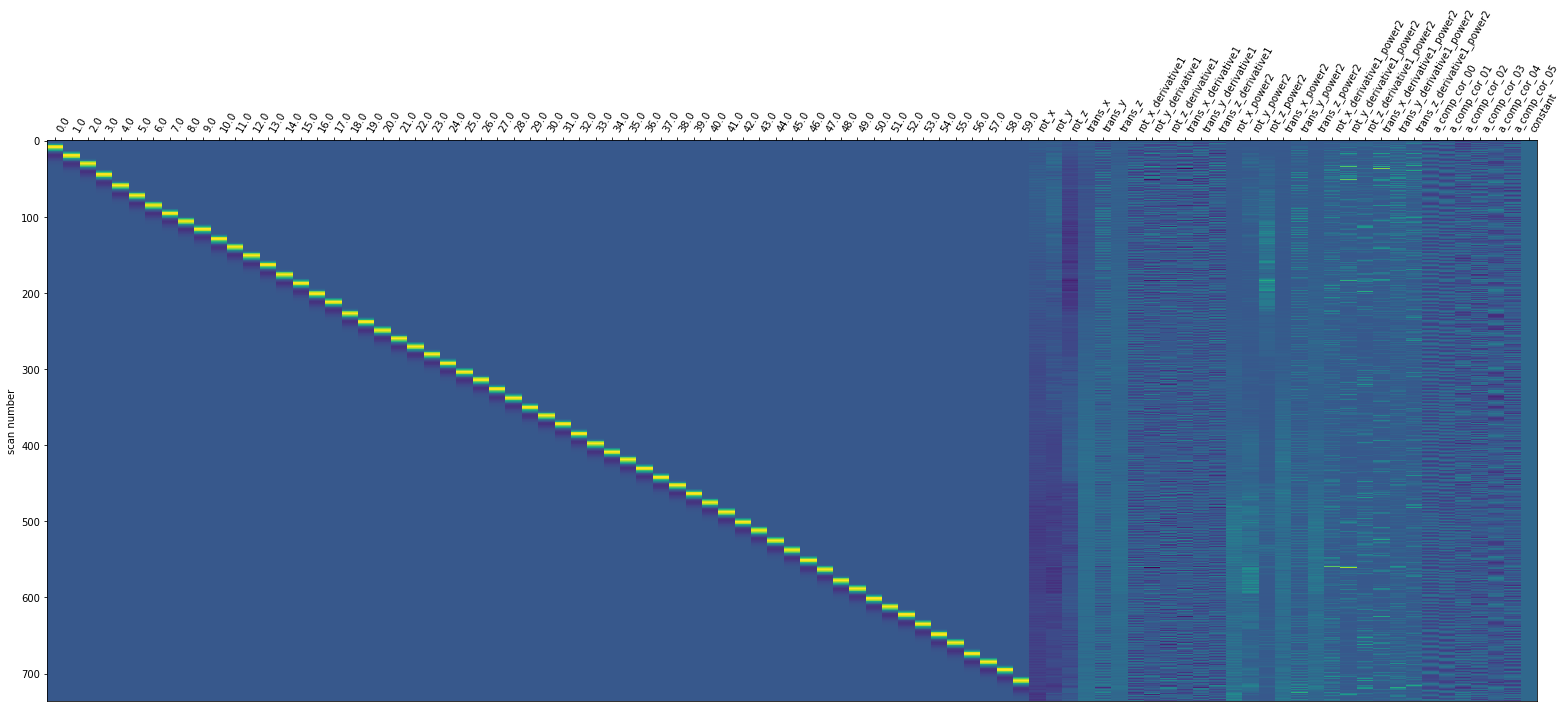

(737, 91)


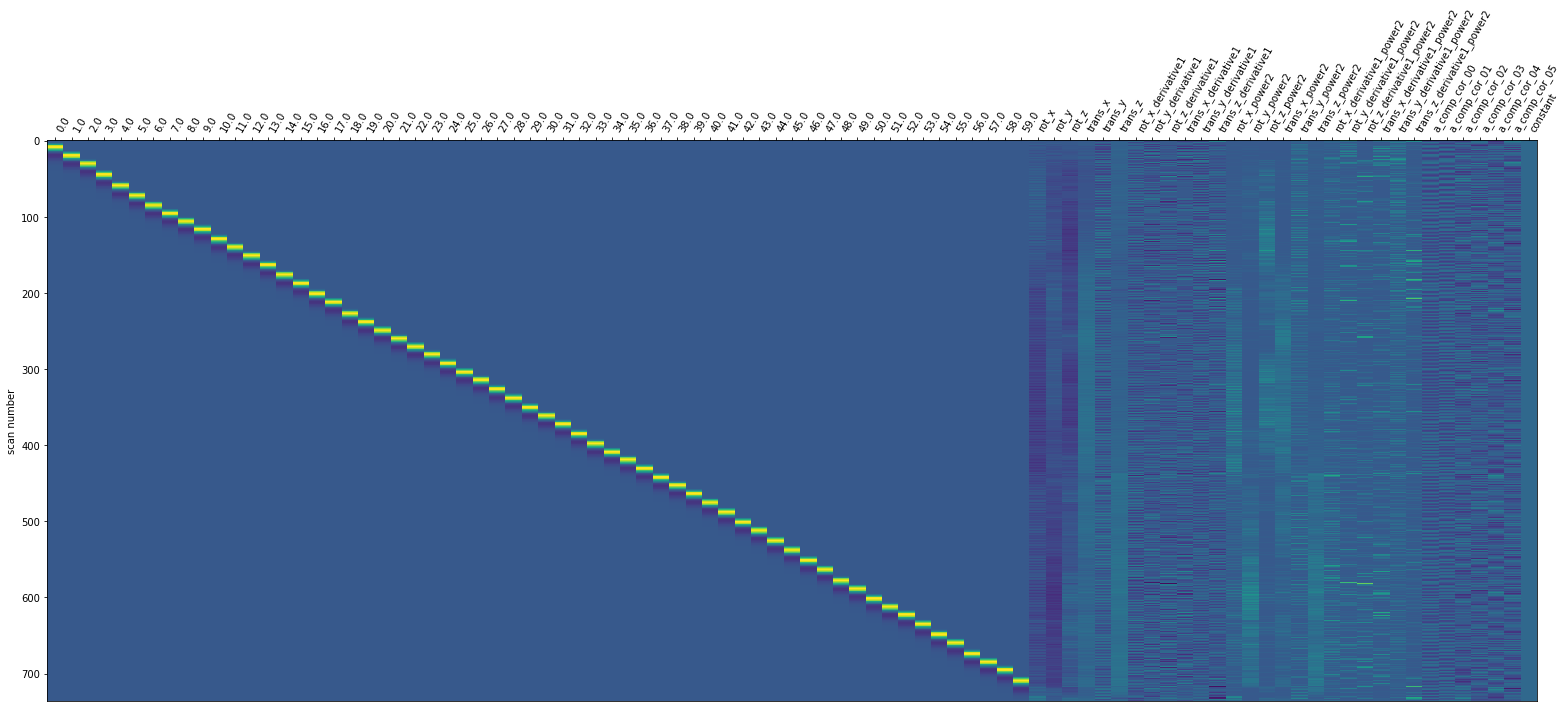

(737, 91)


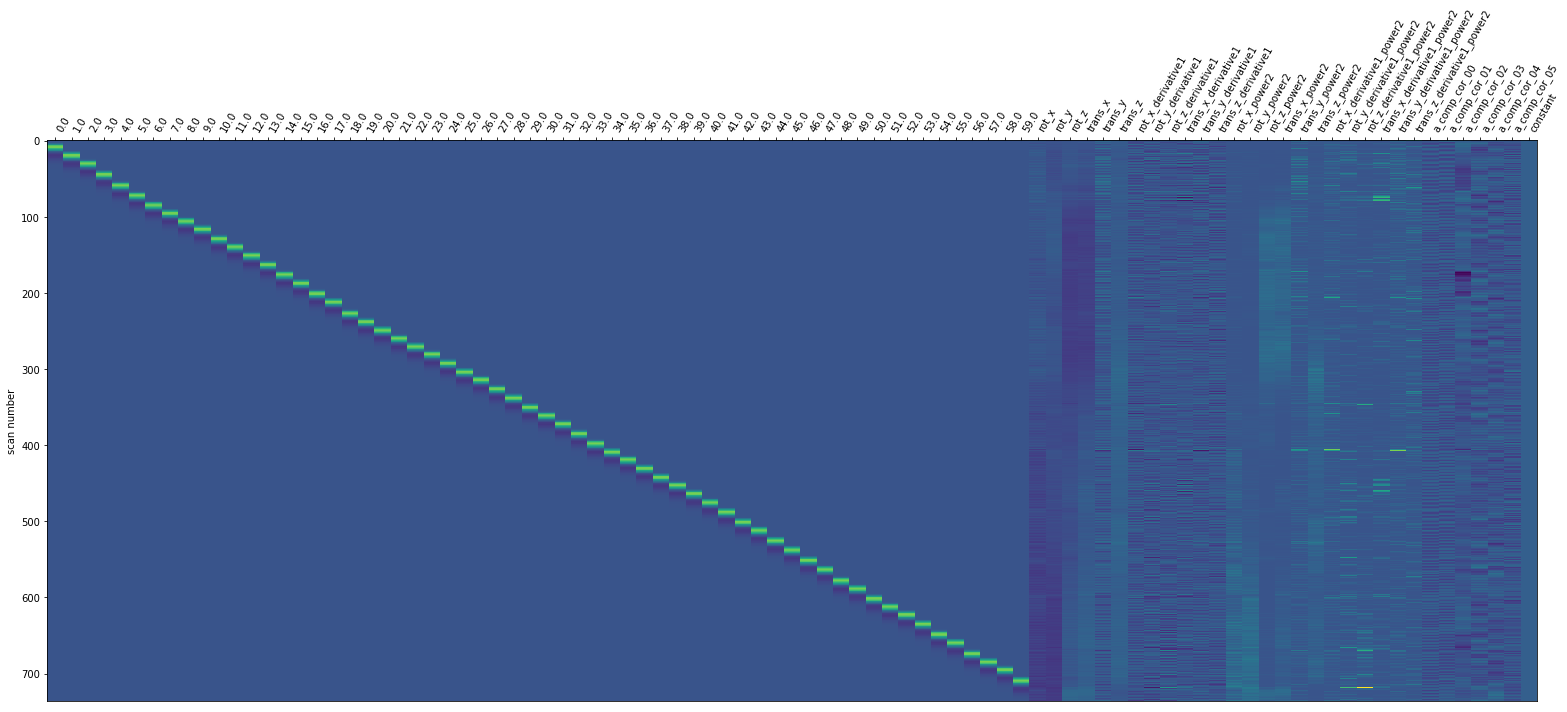

(737, 91)


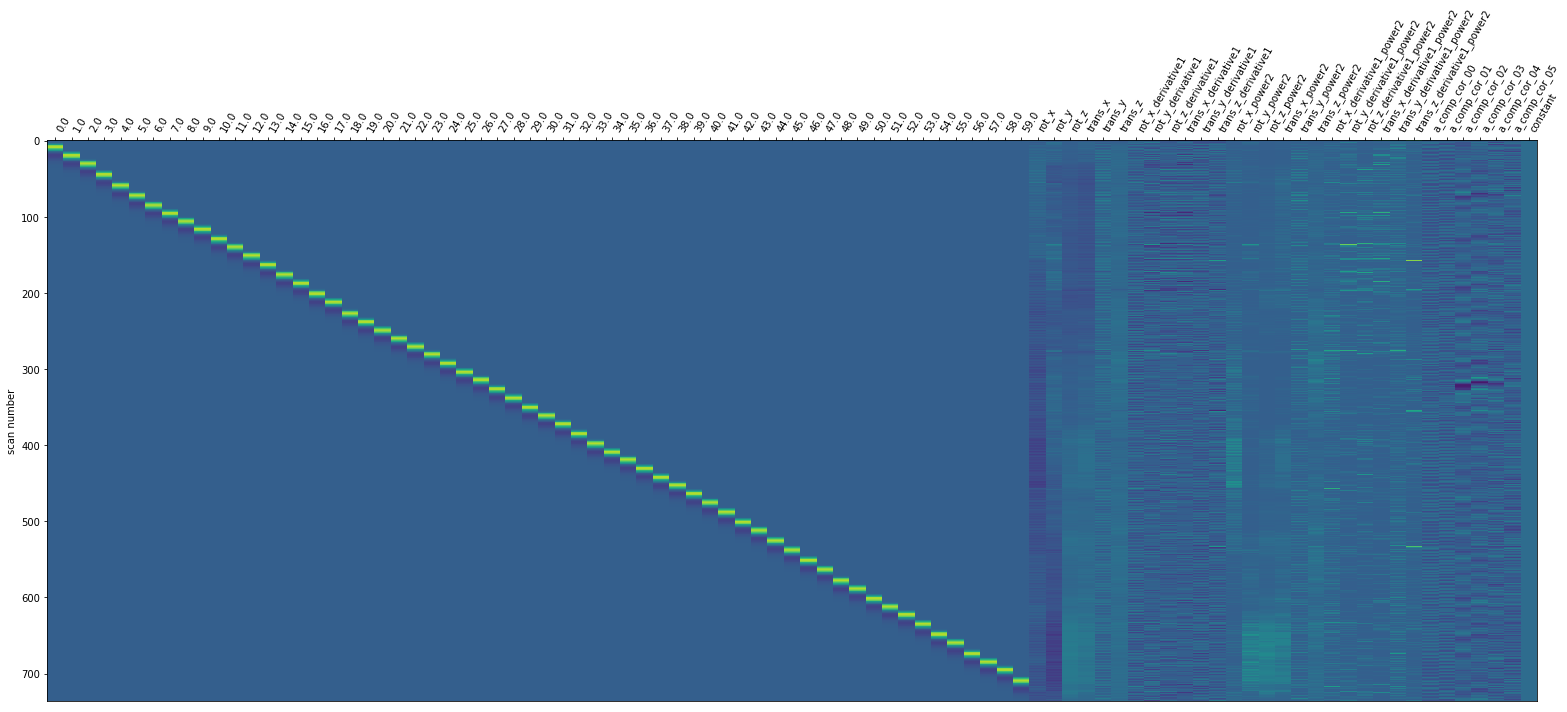

(737, 91)


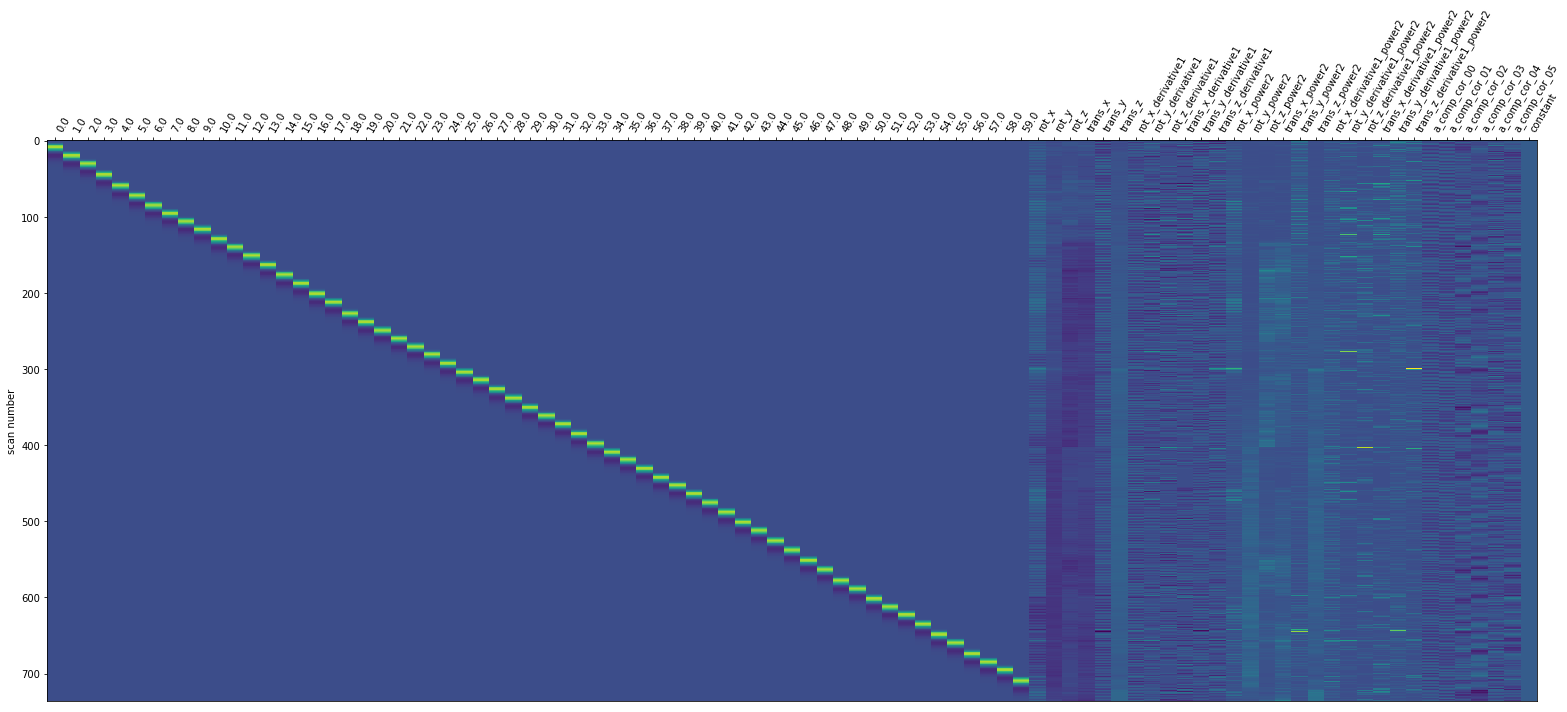

(737, 91)


In [17]:
from nilearn.plotting import plot_design_matrix

for design_matrix in fmri_glm.design_matrices_:

    plot_design_matrix(design_matrix)
    plt.show()
    print(design_matrix.shape)

In [18]:
design_matrix = fmri_glm.design_matrices_[0]

trial_condition_array = np.zeros(91)
trial_condition_array_dummy = np.zeros(91)

trial_condition_array[0:60] = 1.

print(trial_condition_array, trial_condition_array_dummy)

conditions = {
    'trial': trial_condition_array,
    'trial_dummy': trial_condition_array_dummy,
}

trial_response = conditions['trial'] - conditions['trial_dummy']

trial_response_estimate = [trial_response]*run_n # one for each run (all identica)

# this would be efficient, but it doesn't work. (outputs a single map).

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
trial_response_estimates = []
eff_maps = []
z_maps = []
clean_maps = []


for trial in range(60):
    trial_condition_array = np.zeros(91)
    trial_condition_array_dummy = np.zeros(91)

    trial_condition_array[trial] = 1.
    
    print(trial_condition_array)

    conditions = {
        'trial': trial_condition_array,
        'trial_dummy': trial_condition_array_dummy,
    }

    trial_response = conditions['trial'] - conditions['trial_dummy']

    trial_response_estimate = [trial_response]*run_n # one for each run (all identica)

    
    trial_response_estimates.append(trial_response_estimate)
    
    eff_map = fmri_glm.compute_contrast(trial_response_estimate,
                                    output_type='effect_size')

    z_map = fmri_glm.compute_contrast(trial_response_estimate,
                                  output_type='z_score')
    
    eff_maps.append(eff_map)
    z_maps.append(z_map)
    
    print('nans in effect map? ', np.isnan(np.unique(eff_map.get_data())).sum()) # check stat. maps for nans.
    print('nans in z map? ', np.isnan(np.unique(z_map.get_data())).sum()) # check stat. maps for nans.

    clean_map, threshold = threshold_stats_img(
    z_map, alpha=alpha, height_control='fdr',
    cluster_threshold=cluster_threshold)
    
    clean_maps.append(clean_map)
    
    
    z_map.to_filename('/user_data/kbond/trial_response/output/trialwise_z_map_sess{}_{}.nii.gz'.format(session_n, 
    subject, trial))
    clean_map.to_filename('/user_data/kbond/trial_response/output/trialwise_z_map_FDR001_sess{}_{}.nii.gz'.format(session_n, 
    subject, trial))
    eff_map.to_filename('/user_data/kbond/trial_response/output/trialwise_eff_map__sess{}_{}.nii.gz'.format(session_n, 
    subject, trial))


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


nans in effect map?  0
nans in z map?  0
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nans in effect map?  0
nans in z map?  0
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nans in effect map?  0
nans in z map?  0
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nans in effect map?  0
nans in z map?  0
[0

nans in effect map?  0
nans in z map?  0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nans in effect map?  0
nans in z map?  0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nans in effect map?  0
nans in z map?  0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nans in effect map?  0
nans in z map?  0
[0

nans in effect map?  0
nans in z map?  0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nans in effect map?  0
nans in z map?  0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nans in effect map?  0
nans in z map?  0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nans in effect map?  0
nans in z map?  0
[0

In [20]:
# get a random selection of clean_maps to visualize
import random 

random_clean_maps = random.choices(clean_maps, k=5)

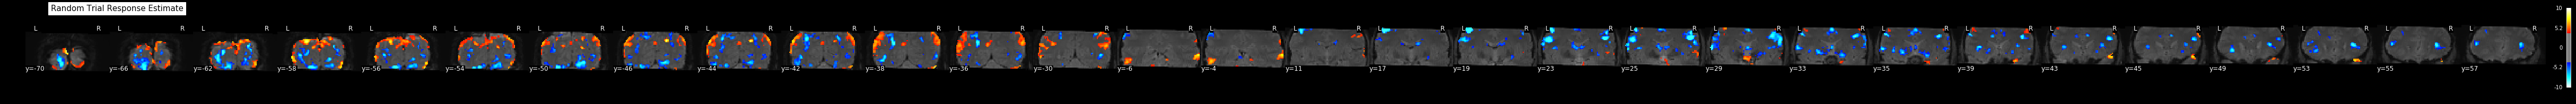

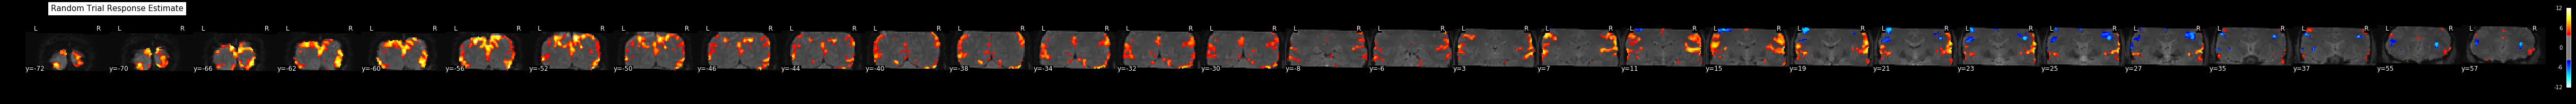

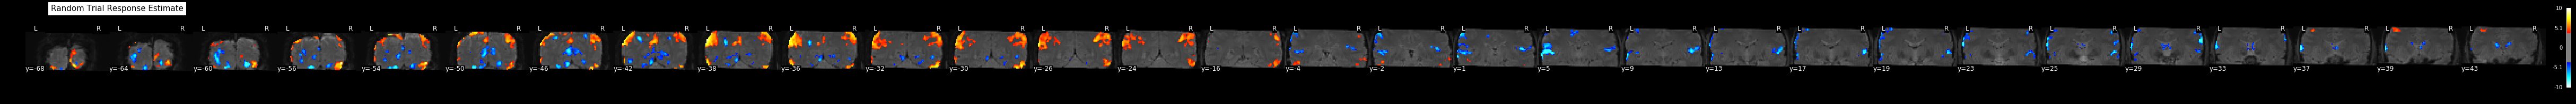

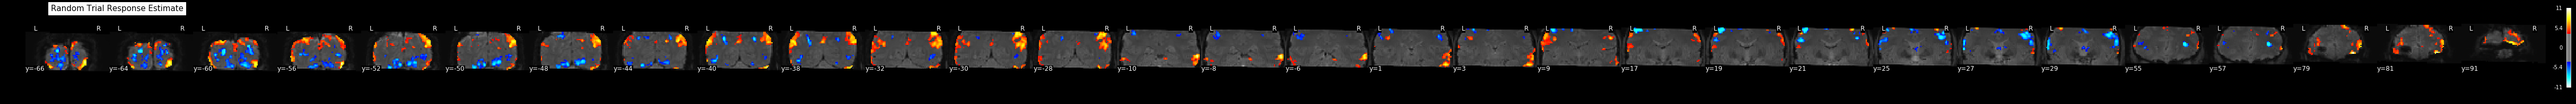

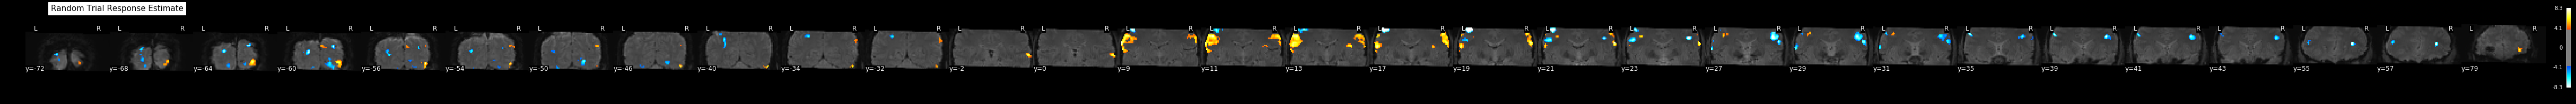

In [22]:
for clean_map in random_clean_maps:
    
    title = 'Random Trial Response Estimate'
    
#     plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
#               display_mode='x', cut_coords=30, black_bg=True,
#               title=title)
    plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='y', cut_coords=30, black_bg=True,
              title=title)


#     plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
#               display_mode='z', cut_coords=30, black_bg=True,
#               title=title)